# Setup

In [1]:
# set random seed to minimize randomness
from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(2)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory   # load as tf.data.Dataset
from tensorflow.data.experimental import cardinality              # get total num of batches -> split val&test
from tensorflow.keras.preprocessing.image import ImageDataGenerator   # data augmentation
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import Model, regularizers, layers, optimizers, losses, metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import cv2

In [3]:
# SET CONSTANTS
IMG_DIR = '/kaggle/input/leukemia/Original'

IMG_SIZE = 224
NUM_CHANNELS = 3
NUM_CLASSES = 4
CLASS_NAMES = ['Benign', 'Early', 'Pre', 'Pro']

SHUFFLE_VALUE = True          # Shuffle images order
BATCH_SIZE = 8

VALIDATION_SPLIT = 0.3        # 70-30 train-val split
SEED_TRAIN_VAL = 420          # Must be same for train_ds and val_ds; reproducibility

# Load Data

In [4]:
# get train images
raw_train_ds = image_dataset_from_directory(
  directory = IMG_DIR,
  image_size = (IMG_SIZE,IMG_SIZE),
  validation_split = VALIDATION_SPLIT,
  batch_size = BATCH_SIZE,
  subset = "training",        # specify training subset
  seed = SEED_TRAIN_VAL,
  color_mode = 'rgb',
  shuffle = SHUFFLE_VALUE,
  label_mode = 'categorical'
)

raw_val_ds = image_dataset_from_directory(
  directory = IMG_DIR,
  image_size = (IMG_SIZE,IMG_SIZE),
  validation_split = VALIDATION_SPLIT,
  batch_size = BATCH_SIZE,
  subset = "validation",      # specify validation subset
  seed = SEED_TRAIN_VAL,
  color_mode = 'rgb',
  shuffle = SHUFFLE_VALUE,
  label_mode = 'categorical'
)

# split validation subset into 2: val & test
val_batches = cardinality(raw_val_ds)
raw_test_ds = raw_val_ds.take((2*val_batches) // 3)
raw_val_ds = raw_val_ds.skip((2*val_batches) // 3)

Found 3256 files belonging to 4 classes.
Using 2280 files for training.
Found 3256 files belonging to 4 classes.
Using 976 files for validation.


In [5]:
class preprocess:
  # data augmentation -> random transformation of train ds to avoid overfitting
  def aug_train_cv(self,img,lbl):
    datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=20,
        horizontal_flip=True,
        vertical_flip=True,
    )
    img = img.numpy().astype('uint8')
    img = datagen.random_transform(img)
    return img,lbl

  def aug_train_pyfunction(self,img,lbl):
    [img,lbl] = tf.py_function(self.aug_train_cv,[img,lbl],[tf.uint8,tf.float32])
    img = tf.cast(img,dtype=tf.float32)
    return img,lbl

  # data augmentation for val-test ds -> rescale pixel
  def aug_val_test_cv(self,img,lbl):
    datagen = ImageDataGenerator(
        rescale = 1./255
    )
    img = img.numpy().astype('uint8')
    img = datagen.random_transform(img)
    return img,lbl

  def aug_val_test_pyfunction(self,img,lbl):
    [img,lbl] = tf.py_function(self.aug_val_test_cv,[img,lbl],[tf.uint8,tf.float32])
    img = tf.cast(img,dtype=tf.float32)
    return img,lbl

  def _fixup_shape(self, img, lbl):
    img.set_shape([None, None, None, NUM_CHANNELS])
    lbl.set_shape([None, NUM_CLASSES])
    return img, lbl

  def pre_vgg19(self, img, lbl):
    return tf.keras.applications.vgg19.preprocess_input(img),lbl
  
  # do prep+aug
  def train(self,ds,batch_size=1):
    aug_ds = ds.unbatch().map(self.aug_train_pyfunction).batch(batch_size)
    fin_ds = aug_ds.map(self._fixup_shape)
    fin_ds = fin_ds.map(self.pre_vgg19)
    return fin_ds
  
  def val_test(self,ds,batch_size=1):
    aug_ds = ds.unbatch().map(self.aug_val_test_pyfunction).batch(batch_size)
    fin_ds = aug_ds.map(self._fixup_shape)
    return fin_ds

In [6]:
train_fin_ds = preprocess().train(raw_train_ds,BATCH_SIZE)
val_fin_ds = preprocess().val_test(raw_val_ds,BATCH_SIZE)
test_fin_ds = preprocess().val_test(raw_test_ds,BATCH_SIZE)

# Training

In [7]:
#Create metrics. Code from https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [8]:
# model architecture
conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(IMG_SIZE, IMG_SIZE, NUM_CHANNELS))
x = conv_base.output
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64,activation='relu',
                kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=conv_base.input, outputs=out)

model.summary()

80134624/80134624 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [9]:
# Make the conv_base NOT trainable:
for layer in conv_base.layers[:]:
    layer.trainable = False

# Compile frozen conv_base + my top layer
model.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy',f1_m])

# Short training ONLY my top layers 
#... so the conv_base weights will not be destroyed by the random intialization of the new weights
history = model.fit(train_fin_ds,
                    epochs=3,
                    validation_data = val_fin_ds,
                    batch_size=BATCH_SIZE,
                    shuffle=False)

Epoch 1/3
285/285 [==============================] - 50s 148ms/step - loss: 1.8618 - accuracy: 0.4399 - f1_m: 0.3291 - val_loss: 1.0689 - val_accuracy: 0.6220 - val_f1_m: 0.3683
Epoch 2/3
285/285 [==============================] - 38s 133ms/step - loss: 1.1275 - accuracy: 0.5456 - f1_m: 0.3896 - val_loss: 0.8701 - val_accuracy: 0.7835 - val_f1_m: 0.6263
Epoch 3/3
285/285 [==============================] - 38s 132ms/step - loss: 1.0519 - accuracy: 0.5711 - f1_m: 0.4458 - val_loss: 0.9261 - val_accuracy: 0.7835 - val_f1_m: 0.6283


In [10]:
# Make last block of the conv_base trainable:
NUM_LAST_BLOCK = 17
for layer in conv_base.layers[:NUM_LAST_BLOCK]:
    layer.trainable = False
for layer in conv_base.layers[NUM_LAST_BLOCK:]:
    layer.trainable = True

model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy',f1_m])

# set callbacks
model_filename = f'/kaggle/working/models/all_fixed-vgg19.h5'
save_best_model = ModelCheckpoint(filepath = model_filename,
                                  monitor = 'val_f1_m',
                                  mode = 'max',
                                  verbose = 1,
                                  save_best_only = True)
early_stopping = EarlyStopping(monitor='val_f1_m',patience=20,mode='max')

history = model.fit(train_fin_ds,
                    epochs=100,
                    validation_data = val_fin_ds,
                    batch_size=BATCH_SIZE,
                    shuffle=False,
                    callbacks=[save_best_model,early_stopping])

Epoch 1/100
    285/Unknown - 39s 126ms/step - loss: 0.9092 - accuracy: 0.6557 - f1_m: 0.5293
Epoch 1: val_f1_m improved from -inf to 0.64835, saving model to /kaggle/working/models/all_fixed-vgg19.h5
285/285 [==============================] - 42s 136ms/step - loss: 0.9092 - accuracy: 0.6557 - f1_m: 0.5293 - val_loss: 0.9694 - val_accuracy: 0.7896 - val_f1_m: 0.6483
Epoch 2/100
285/285 [==============================] - ETA: 0s - loss: 0.8201 - accuracy: 0.6934 - f1_m: 0.5783
Epoch 2: val_f1_m improved from 0.64835 to 0.72516, saving model to /kaggle/working/models/all_fixed-vgg19.h5
285/285 [==============================] - 38s 135ms/step - loss: 0.8201 - accuracy: 0.6934 - f1_m: 0.5783 - val_loss: 1.0026 - val_accuracy: 0.8140 - val_f1_m: 0.7252
Epoch 3/100
285/285 [==============================] - ETA: 0s - loss: 0.6002 - accuracy: 0.7623 - f1_m: 0.7267
Epoch 3: val_f1_m improved from 0.72516 to 0.79753, saving model to /kaggle/working/models/all_fixed-vgg19.h5
285/285 [==========

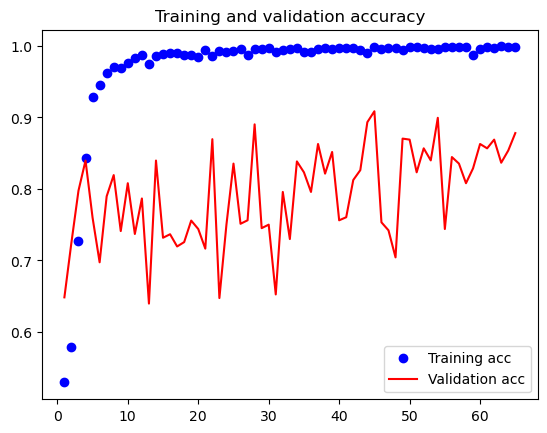

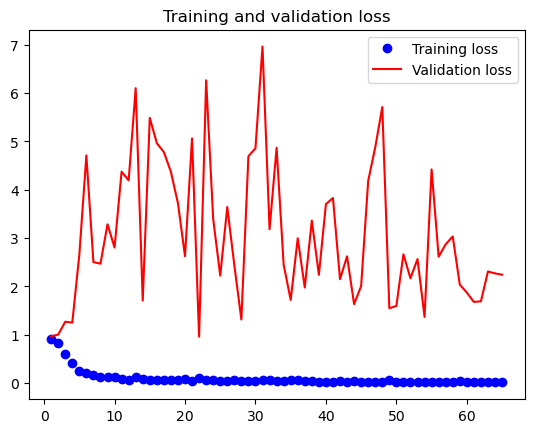

In [11]:
f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(f1) + 1)
plt.plot(epochs, f1, 'bo', label='Training acc')
plt.plot(epochs, val_f1, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [12]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_fin_ds:   # use dataset.unbatch() with repeat
    # append true labels
    truth = np.argmax(label_batch, axis=1)
    y_true.append(truth)
    # compute predictions
    preds = model.predict(image_batch,verbose=0)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis = - 1))
# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)
# classification report
report = classification_report(correct_labels, predicted_labels, digits= 4, output_dict=True,)
report_df = pd.DataFrame(report).transpose()

report_df

,precision,recall,f1-score,support
0,0.762295,1.000000,0.865116,93.000000
1,0.821705,0.968037,0.888889,219.000000
2,1.000000,0.640449,0.780822,178.000000
3,0.922078,0.898734,0.910256,158.000000
accuracy,0.865741,0.865741,0.865741,0.865741
macro avg,0.876520,0.876805,0.861271,648.000000
weighted avg,0.886628,0.865741,0.861002,648.000000


In [13]:
conf_mtx = confusion_matrix(correct_labels, predicted_labels)

conf_mtx

array([[ 93,   0,   0,   0],
       [  6, 212,   0,   1],
       [  9,  44, 114,  11],
       [ 14,   2,   0, 142]])

# GradCAM

## Sample Image

Directory changed to: /kaggle/input/leukemia
Current sample name: WBC-Malignant-Pre-117.jpg
Current sample path: Original/Pre/WBC-Malignant-Pre-117.jpg


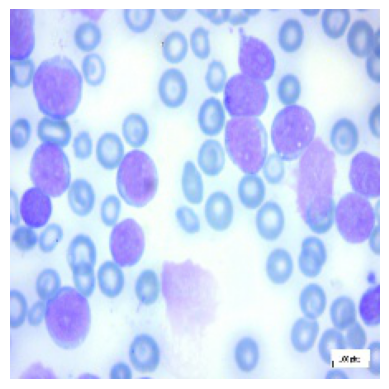

In [14]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# change working directory
PATH_all = '/kaggle/input/leukemia'
os.chdir(PATH_all)
print(f'Directory changed to: {os.getcwd()}')

# pick one sample
main_dir = 'Original'
sub_main_dir = 'Pre'
sample_image_name = os.listdir(os.path.join(main_dir, sub_main_dir))[87]
print(f'Current sample name: {sample_image_name}')

sample_image_path = os.path.join(main_dir, sub_main_dir, sample_image_name)
print(f'Current sample path: {sample_image_path}')

# load image
img = load_img(sample_image_path)
# visuliaze image
plt.imshow(img)
plt.axis('off')
plt.show()

## GradCAM

In [20]:
from tensorflow import keras

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 [==============================] - 0s 22ms/step
Predicted: Pre


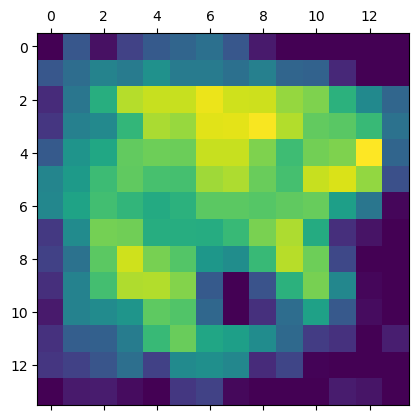

In [24]:
# Prepare image
img_array = tf.keras.applications.vgg19.preprocess_input(get_img_array(sample_image_path, size=(IMG_SIZE,IMG_SIZE)))

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
labels = ['Benign','Early','Pre','Pro']
preds = model.predict(img_array)
print("Predicted:", labels[preds.argmax(1)[0]])

# Generate class activation heatmap
last_conv_layer_name = 'block5_conv4'
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()


In [30]:
import matplotlib.cm as cm
from IPython.display import Image, display

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

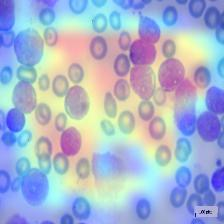

In [31]:
save_and_display_gradcam(sample_image_path, heatmap, cam_path='/kaggle/working/cam.jpg')

## GradCAM Refactor

In [20]:
import numpy as np
import matplotlib.cm as cm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array, array_to_img
from tensorflow.keras.models import Model

# gradcam implementation taken from https://keras.io/examples/vision/grad_cam/ 
class gradCAM:
    def __init__(self, img_path, model, size=(224,224), last_conv_layer_name='block5_conv4'):
        self.img_array = self.get_img_array(img_path,size)
        self.model = model
        self.model.layers[-1].activation = None
        self.last_conv_layer_name = last_conv_layer_name
        self.heatmap = self.make_gradcam_heatmap() 
        
    def get_img_array(self, img_path, size):
        img = load_img(img_path, target_size=size) # `img` is a PIL image of size 299x299
        self.img = img # class instance variable
        array = img_to_array(img) # `array` is a float32 Numpy array of shape (299, 299, 3)
        array = np.expand_dims(array, axis=0) # We add a dimension to transform our array into a "batch" of size (1, 299, 299, 3)
        return array
    
    def make_gradcam_heatmap(self, pred_index=None):
        # First, we create a model that maps the input image to the activations
        # of the last conv layer as well as the output predictions
        grad_model = Model(
            [self.model.inputs], [self.model.get_layer(self.last_conv_layer_name).output, self.model.output]
        )
        # Then, we compute the gradient of the top predicted class for our input image
        # with respect to the activations of the last conv layer
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(self.img_array)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]
        # This is the gradient of the output neuron (top predicted or chosen)
        # with regard to the output feature map of the last conv layer
        grads = tape.gradient(class_channel, last_conv_layer_output)
        # This is a vector where each entry is the mean intensity of the gradient
        # over a specific feature map channel
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        # We multiply each channel in the feature map array
        # by "how important this channel is" with regard to the top predicted class
        # then sum all the channels to obtain the heatmap class activation
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        # For visualization purpose, we will also normalize the heatmap between 0 & 1
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()
    
    def display_gradcam(self, alpha=0.4):
        img = img_to_array(self.img)
        self.heatmap = np.uint8(255 * self.heatmap) # Rescale heatmap to a range 0-255
        jet = cm.get_cmap("jet") # Use jet colormap to colorize heatmap
        # Use RGB values of the colormap
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[self.heatmap]
        # Create an image with RGB colorized heatmap
        jet_heatmap = array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = img_to_array(jet_heatmap)
        # Superimpose the heatmap on original image
        superimposed_img = jet_heatmap * alpha + img
        superimposed_img = array_to_img(superimposed_img)
        return superimposed_img

type(img_gradcam): <class 'PIL.Image.Image'>


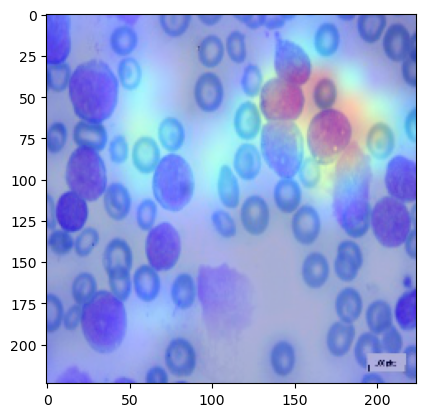

In [21]:
img_path = sample_image_path
img_size = (224,224)
last_conv_layer_name = 'block5_conv4'
img_gradcam = gradCAM(img_path=img_path,size=img_size,model=model,last_conv_layer_name=last_conv_layer_name).display_gradcam()
print(f'type(img_gradcam): {type(img_gradcam)}')
plt.imshow(img_gradcam)